# SurvTrace Reproducibility and Ablation Study
This paper reproduces the results from SurvTRACE, which introduces a transformer-based model that can handle competing events and does not rely on assumptions about the underlying survival distribution. The model addresses the issue of implicit confounders in observational settings with multiple events, which can introduce selection bias by influencing predicted survival probabilities with irrelevant factors. The authors claim that SurvTRACE perform better than existing models, and attribute the increased performance on the use of a transformer in the model architecture as well as the use of a logistic hazard loss function. To validate the authors' claims, SurvTRACE was first trained with three datasets used in the original paper: SEER, SUPPORT, and METABRIC. These trained model performed similarly to what was reported in the original paper based on their TD concordance. It can also thus be inferred that SurvTRACE can perform better than existing models based on lower performance reported in the original paper. Ablation experiments were then carried out to verify whether the increased performance can be attributed to the transformer and loss function. SurvTRACE models without either the transformer or the loss function were trained on the SEER dataset and a performance decrease is observed. Finally, an additional ablation study was carried out by training SurvTRACE on a small subset of the SEER dataset to explore the potential application on disease conditions that are less studied. We found that SurvTRACE performed similarly even when using 25% of the original SEER dataset, suggesting that it is a robust model that can potentially be used for survival analysis in rarer diseases.

In [1]:
# %pip install -r requirements.txt

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import easydict
from torch import Tensor, device, dtype, nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from sksurv.metrics import concordance_index_ipcw, brier_score
import torchtuples as tt

from pycox.datasets import metabric, support
from pycox.models import LogisticHazard, DeepHit
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
from pycox.evaluation import EvalSurv
from pycox.models.loss import NLLPCHazardLoss
from pycox.preprocessing.discretization import (make_cuts, IdxDiscUnknownC, _values_if_series,
    DiscretizeUnknownC, Duration2Idx)


In [3]:
from survtrace.dataset import load_data
from survtrace.evaluate_utils import Evaluator
from survtrace.utils import set_random_seed
from survtrace.model import SurvTraceMulti, SurvTraceSingle
from survtrace.train_utils import Trainer
from survtrace.config import STConfig

In [4]:
np.random.seed(42)
_ = torch.manual_seed(42)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## DeepHit Specifications

In [5]:
# class SimpleMLP(torch.nn.Module):
#     def __init__(self, in_features, num_nodes, num_risks, out_features, batch_norm=True,
#                  dropout=None):
#         super().__init__()
#         self.num_risks = num_risks
#         self.mlp = tt.practical.MLPVanilla(
#             in_features, num_nodes, num_risks * out_features,
#             batch_norm, dropout,
#         )
        
#     def forward(self, input):
#         out = self.mlp(input)
#         return out.view(out.size(0), self.num_risks, -1)

# class CauseSpecificNet(torch.nn.Module):
#     def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
#                  out_features, batch_norm=True, dropout=None):
#         super().__init__()
#         self.shared_net = tt.practical.MLPVanilla(
#             in_features, num_nodes_shared[:-1], num_nodes_shared[-1],
#             batch_norm, dropout,
#         )
#         self.risk_nets = torch.nn.ModuleList()
#         for _ in range(num_risks):
#             net = tt.practical.MLPVanilla(
#                 num_nodes_shared[-1], num_nodes_indiv, out_features,
#                 batch_norm, dropout,
#             )
#             self.risk_nets.append(net)

#     def forward(self, input):
#         out = self.shared_net(input)
#         out = [net(out) for net in self.risk_nets]
#         out = torch.stack(out, dim=1)
#         return out

## SEER Dataset Loading and Visualization

In [6]:
STConfig['data'] = 'seer'
STConfig['num_hidden_layers'] = 2
STConfig['hidden_size'] = 16
STConfig['intermediate_size'] = 64
STConfig['num_attention_heads'] = 2
STConfig['initializer_range'] = .02
STConfig['early_stop_patience'] = 5

df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(STConfig)
train_set = (df_train, df_y_train)
val_set = (df_val, df_y_val)




In [7]:
df.iloc[:, 0:13].describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Sex,Year of diagnosis,"Race recode (W, B, AI, API)",Histologic Type ICD-O-3,Laterality,Sequence number,ER Status Recode Breast Cancer (1990+),PR Status Recode Breast Cancer (1990+),Summary stage 2000 (1998-2017),RX Summ--Surg Prim Site (1998+),Reason no cancer-directed surgery,First malignant primary indicator,Diagnostic Confirmation
count,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00
mean,0.01,6.34,2.72,1.43,2.48,4.40,1.71,1.59,1.24,8.74,4.55,0.82,3.00
std,0.09,2.79,0.62,4.58,1.50,2.44,0.56,0.61,0.56,8.04,1.38,0.38,0.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,5.00,3.00,0.00,1.00,1.00,2.00,1.00,1.00,4.00,5.00,1.00,3.00
50%,0.00,7.00,3.00,0.00,1.00,6.00,2.00,2.00,1.00,5.00,5.00,1.00,3.00
75%,0.00,9.00,3.00,1.00,4.00,6.00,2.00,2.00,2.00,13.00,5.00,1.00,3.00
max,1.00,10.00,3.00,74.00,4.00,6.00,2.00,2.00,2.00,47.00,5.00,1.00,5.00


In [8]:
df.iloc[:, 14:25].describe().apply(lambda s: s.apply('{0:.2f}'.format))


,Regional nodes examined (1988+),CS tumor size (2004-2015),Total number of benign/borderline tumors for patient,Total number of in situ/malignant tumors for patient,duration,event_heart,event_breast,event_0,event_1,duration_disc,proportion
count,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00,476746.00
mean,-0.00,0.00,0.00,0.00,67.41,0.05,0.18,0.18,0.05,2.36,0.51
std,1.00,1.00,1.00,1.00,31.45,0.21,0.39,0.39,0.21,0.97,0.29
min,-0.48,-0.38,-0.08,-0.57,1.00,0.00,0.00,0.00,0.00,0.00,0.02
25%,-0.43,-0.34,-0.08,-0.57,48.00,0.00,0.00,0.00,0.00,2.00,0.25
50%,-0.32,-0.30,-0.08,-0.57,69.00,0.00,0.00,0.00,0.00,3.00,0.52
75%,-0.00,-0.25,-0.08,0.94,92.00,0.00,0.00,0.00,0.00,3.00,0.76
max,4.83,3.44,57.86,28.18,121.00,1.00,1.00,1.00,1.00,3.00,1.00


## DeepHit - SEER

In [9]:



# df_train, df_y_train = train_set
# x_train = df_train.values.astype('float32')
# y_train = (df_y_train['duration'].values.astype('int64'), (df_y_train['event_0'].values + df_y_train['event_1'].values * 2).astype('int64'))

# df_val, df_y_val = val_set
# x_val = df_val.values.astype('float32')
# y_val = (df_y_val['duration'].values.astype('int64'), (df_y_val['event_0'].values + df_y_val['event_1'].values * 2).astype('int64'))
# val = (x_val, y_val)

# in_features = x_train.shape[1]
# num_nodes_shared = [64, 64]
# num_nodes_indiv = [32]
# num_risks = 2
# out_features = len(STConfig['labtrans'].cuts)
# batch_norm = True
# dropout = 0.1

# net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
#                     out_features, batch_norm, dropout).to(DEVICE)
# optimizer = tt.optim.AdamWR(lr=0.01, decoupled_weight_decay=0.01,
#                         cycle_eta_multiplier=0.8)
# DeepHitModel = DeepHit(net, optimizer, alpha=0.2, sigma=0.1,
#             duration_index=STConfig['labtrans'].cuts)
# epochs = 50
# batch_size = 256
# callbacks = [tt.callbacks.EarlyStoppingCycle()]
# verbose = True 

# x_train, y_train = torch.tensor(x_train).to(DEVICE), (torch.tensor(y_train[0]).to(DEVICE), torch.tensor(y_train[1]).to(DEVICE))
# x_val, y_val = torch.tensor(x_val).to(DEVICE), (torch.tensor(y_val[0]).to(DEVICE), torch.tensor(y_val[1]).to(DEVICE))
# val = (x_val, y_val)

# log = DeepHitModel.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)
# log = log.to_pandas()




In [10]:
# predictions = DeepHitModel.predict(x_val)
# event_types = y_val[0].cpu().numpy()
# event_times = y_val[1].cpu().numpy()

# cif = DeepHitModel.predict_cif(x_val)
# cif1 = pd.DataFrame(cif[0].cpu().numpy(), DeepHitModel.duration_index)
# ev1 = EvalSurv(cif1, event_times, event_types > 0, censor_surv='km')
# ev1.concordance_td()

# cif1 = pd.DataFrame(cif[0].cpu().numpy(), DeepHitModel.duration_index)
# cif2 = pd.DataFrame(cif[1].cpu().numpy(), DeepHitModel.duration_index)
# ev1 = EvalSurv(1-cif1, y_val_duration, y_val_event == 1, censor_surv='km')
# ev2 = EvalSurv(1-cif2, y_val_duration, y_val_event == 2, censor_surv='km')

# cis.append(concordance_index_ipcw(et_train, et_test, risk[:, i+1].to("cpu").numpy(), times[i])[0])  

## SurvTRACE - SEER
The SurvTRACE model without ablations was trained with the SEER dataset and evaluated using TD concordance calculated by the evaluator object from the SurvTRACE package.

In [11]:
hparams = {
    'batch_size': 1024,
    'weight_decay': 0,
    'learning_rate': 1e-4,
    'epochs': 100,
}
SurvTraceSeer = SurvTraceMulti(STConfig).to(DEVICE)
SurvTraceSeer_trainer = Trainer(SurvTraceSeer)
train_loss, val_loss = SurvTraceSeer_trainer.fit((df_train, df_y_train), (df_val, df_y_val),
    batch_size=hparams['batch_size'],
    epochs=hparams['epochs'],
    learning_rate=hparams['learning_rate'],
    weight_decay=hparams['weight_decay'],
    val_batch_size=10000,)


use pytorch-cuda for training.


c:\Users\Jackie Chang\Desktop\DLH-SurvTrace-main\survtrace\train_utils.py:208: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1420.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


[Train-0]: 2.9760685688784334
[Val-0]: 2.303372383117676
[Train-1]: 0.7216343528964893
[Val-1]: 0.6906883716583252
[Train-2]: 0.6844168733171865
[Val-2]: 0.6782993078231812
[Train-3]: 0.6789033678518671
[Val-3]: 0.6754992008209229
[Train-4]: 0.677108012089113
[Val-4]: 0.6724416017532349
[Train-5]: 0.6746655793822541
[Val-5]: 0.6721491813659668
[Train-6]: 0.6736950274227428
[Val-6]: 0.6704277992248535
[Train-7]: 0.6725244483574718
[Val-7]: 0.6695846319198608
[Train-8]: 0.6718956274645669
[Val-8]: 0.6687475442886353
[Train-9]: 0.6711800416716102
[Val-9]: 0.6684685945510864
[Train-10]: 0.6706843775551335
[Val-10]: 0.6687781810760498
EarlyStopping counter: 1 out of 5
[Train-11]: 0.6701725078683322
[Val-11]: 0.668524980545044
EarlyStopping counter: 2 out of 5
[Train-12]: 0.6699310697260357
[Val-12]: 0.6672793626785278
[Train-13]: 0.6695130887080212
[Val-13]: 0.6674829125404358
EarlyStopping counter: 1 out of 5
[Train-14]: 0.6689976824789631
[Val-14]: 0.6685466766357422
EarlyStopping counter

In [35]:
evaluator = Evaluator(df, df_train.index)
evaluator.eval(SurvTraceSeer, (df_test, df_y_test))

******************************
start evaluation
******************************


c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con


Event: 0 For 0.25 quantile,
TD Concordance Index - IPCW: 0.9033432086254986
Brier Score: 0.03593080123945568
Event: 0 For 0.5 quantile,
TD Concordance Index - IPCW: 0.8820621444269189
Brier Score: 0.06045311869879083
Event: 0 For 0.75 quantile,
TD Concordance Index - IPCW: 0.8649312485483952
Brier Score: 0.08189422303173148
Event: 1 For 0.25 quantile,
TD Concordance Index - IPCW: 0.7862581957187452
Brier Score: 0.007403492846374771
Event: 1 For 0.5 quantile,
TD Concordance Index - IPCW: 0.7870278852379744
Brier Score: 0.016000015042350945
Event: 1 For 0.75 quantile,
TD Concordance Index - IPCW: 0.776352535848915
Brier Score: 0.027978165449578166


defaultdict(list,
            {'0.25_ipcw_0': 0.9033432086254986,
             '0.25_brier_0': 0.03593080123945568,
             '0.5_ipcw_0': 0.8820621444269189,
             '0.5_brier_0': 0.06045311869879083,
             '0.75_ipcw_0': 0.8649312485483952,
             '0.75_brier_0': 0.08189422303173148,
             '0.25_ipcw_1': 0.7862581957187452,
             '0.25_brier_1': 0.007403492846374771,
             '0.5_ipcw_1': 0.7870278852379744,
             '0.5_brier_1': 0.016000015042350945,
             '0.75_ipcw_1': 0.776352535848915,
             '0.75_brier_1': 0.027978165449578166})

## SUPPORT Dataset Loading and Visualization

In [13]:
# define the setup parameters
STConfig['data'] = 'support'
STConfig['num_event'] = 1

hparams = {
    'batch_size': 128,
    'weight_decay': 0,
    'learning_rate': 1e-3,
    'epochs': 20,
}
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(STConfig)

df.describe().apply(lambda s: s.apply('{0:.2f}'.format))



,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
count,8873.00,8873.00,8873.00,8873.00,8873.00,8873.00,8873.00,8873.00,8873.00,8873.00,8873.00,8873.00,8873.00,8873.00,8873.00,8873.00
mean,62.63,0.44,1.87,1.25,0.19,0.03,0.94,84.53,97.48,23.36,37.11,137.57,12.35,1.78,478.64,0.68
std,15.62,0.50,1.34,0.62,0.40,0.18,0.58,27.82,31.70,9.63,1.26,6.07,9.27,1.69,560.83,0.47
min,18.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,31.70,110.00,0.00,0.10,3.00,0.00
25%,52.75,0.00,1.00,1.00,0.00,0.00,1.00,63.00,72.00,18.00,36.20,134.00,7.00,0.90,26.00,0.00
50%,64.83,0.00,2.00,1.00,0.00,0.00,1.00,77.00,100.00,24.00,36.70,137.00,10.60,1.20,231.00,1.00
75%,74.03,1.00,3.00,1.00,0.00,0.00,1.00,107.00,120.00,28.00,38.20,141.00,15.30,1.90,763.00,1.00
max,101.85,1.00,9.00,5.00,1.00,1.00,2.00,195.00,300.00,90.00,41.70,181.00,200.00,21.50,2029.00,1.00


## SurvTRACE - SUPPORT
The SurvTRACE model without ablations was trained with the SUPPORT dataset and evaluated using TD concordance calculated by the evaluator object from the SurvTRACE package.

In [14]:
model = SurvTraceSingle(STConfig)
trainer = Trainer(model)
train_loss, val_loss = trainer.fit((df_train, df_y_train), (df_val, df_y_val),
        batch_size=hparams['batch_size'],
        epochs=hparams['epochs'],
        learning_rate=hparams['learning_rate'],
        weight_decay=hparams['weight_decay'],)

use pytorch-cuda for training.
[Train-0]: 69.49956834316254
[Val-0]: 1.3877462148666382
[Train-1]: 58.55283069610596
[Val-1]: 1.349938154220581
[Train-2]: 58.08263158798218
[Val-2]: 1.370281457901001
EarlyStopping counter: 1 out of 5
[Train-3]: 57.78693330287933
[Val-3]: 1.3436068296432495
[Train-4]: 57.56906247138977
[Val-4]: 1.3464226722717285
EarlyStopping counter: 1 out of 5
[Train-5]: 57.29101920127869
[Val-5]: 1.3460872173309326
EarlyStopping counter: 2 out of 5
[Train-6]: 57.27627182006836
[Val-6]: 1.34273099899292
[Train-7]: 57.16512668132782
[Val-7]: 1.3605945110321045
EarlyStopping counter: 1 out of 5
[Train-8]: 56.99452233314514
[Val-8]: 1.3547546863555908
EarlyStopping counter: 2 out of 5
[Train-9]: 56.875293254852295
[Val-9]: 1.346466064453125
EarlyStopping counter: 3 out of 5
[Train-10]: 56.77872693538666
[Val-10]: 1.3448930978775024
EarlyStopping counter: 4 out of 5
[Train-11]: 56.64685416221619
[Val-11]: 1.3438853025436401
EarlyStopping counter: 5 out of 5
early stops a

In [15]:
evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))

******************************
start evaluation
******************************
For 0.25 quantile,
TD Concordance Index - IPCW: 0.6521908560171059
Brier Score: 0.13451221546819953
For 0.5 quantile,
TD Concordance Index - IPCW: 0.6228850608765065
Brier Score: 0.20879744735506525
For 0.75 quantile,
TD Concordance Index - IPCW: 0.6015098129932681
Brier Score: 0.2330643214526076


defaultdict(list,
            {'0.25_ipcw': 0.6521908560171059,
             '0.25_brier': 0.13451221546819953,
             '0.5_ipcw': 0.6228850608765065,
             '0.5_brier': 0.20879744735506525,
             '0.75_ipcw': 0.6015098129932681,
             '0.75_brier': 0.2330643214526076})

## SUPPORT Dataset Loading and Visualization

In [16]:

# define the setup parameters
STConfig['data'] = 'metabric'
STConfig['num_event'] = 1

hparams = {
    'batch_size': 128,
    'weight_decay': 0,
    'learning_rate': 1e-3,
    'epochs': 20,
}
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(STConfig)

df.describe().apply(lambda s: s.apply('{0:.2f}'.format))


c:\Users\Jackie Chang\Desktop\DLH-SurvTrace-main\survtrace\utils.py:78: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
count,1904.00,1904.00,1904.00,1904.00,1904.00,1904.00,1904.00,1904.00,1904.00,1904.00,1904.00
mean,6.21,6.24,10.77,5.87,0.62,0.60,0.21,0.76,61.09,125.03,0.58
std,0.86,1.02,1.36,0.34,0.49,0.49,0.41,0.43,12.98,76.33,0.49
min,5.16,4.86,6.37,5.10,0.00,0.00,0.00,0.00,21.93,0.00,0.00
25%,5.69,5.41,9.97,5.62,0.00,0.00,0.00,1.00,51.38,60.82,0.00
50%,5.95,5.88,10.53,5.82,1.00,1.00,0.00,1.00,61.77,114.90,1.00
75%,6.46,6.90,11.16,6.06,1.00,1.00,0.00,1.00,70.59,184.47,1.00
max,14.44,9.93,14.64,7.66,1.00,1.00,1.00,1.00,96.29,355.20,1.00


## SurvTRACE - METABRIC
The SurvTRACE model without ablations was trained with the METABRIC dataset and evaluated using TD concordance calculated by the evaluator object from the SurvTRACE package.

In [17]:

model = SurvTraceSingle(STConfig)
trainer = Trainer(model)
train_loss, val_loss = trainer.fit((df_train, df_y_train), (df_val, df_y_val),
        batch_size=hparams['batch_size'],
        epochs=hparams['epochs'],
        learning_rate=hparams['learning_rate'],
        weight_decay=hparams['weight_decay'],)

use pytorch-cuda for training.
[Train-0]: 17.016679644584656
[Val-0]: 1.3102798461914062
[Train-1]: 15.152567625045776
[Val-1]: 1.1598601341247559
[Train-2]: 13.263692021369934
[Val-2]: 1.145556092262268
[Train-3]: 11.608664631843567
[Val-3]: 1.1200928688049316
[Train-4]: 10.87654435634613
[Val-4]: 1.124851107597351
EarlyStopping counter: 1 out of 5
[Train-5]: 10.790985822677612
[Val-5]: 1.1358267068862915
EarlyStopping counter: 2 out of 5
[Train-6]: 10.58698844909668
[Val-6]: 1.1241111755371094
EarlyStopping counter: 3 out of 5
[Train-7]: 10.750947892665863
[Val-7]: 1.0970479249954224
[Train-8]: 10.778635561466217
[Val-8]: 1.101806402206421
EarlyStopping counter: 1 out of 5
[Train-9]: 10.622157514095306
[Val-9]: 1.1121330261230469
EarlyStopping counter: 2 out of 5
[Train-10]: 10.509716629981995
[Val-10]: 1.125728726387024
EarlyStopping counter: 3 out of 5
[Train-11]: 10.431023359298706
[Val-11]: 1.0957859754562378
[Train-12]: 10.583075225353241
[Val-12]: 1.1066266298294067
EarlyStoppi

In [18]:
evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))

******************************
start evaluation
******************************
For 0.25 quantile,
TD Concordance Index - IPCW: 0.7135106078431047
Brier Score: 0.11492162956562897
For 0.5 quantile,
TD Concordance Index - IPCW: 0.658611861785142
Brier Score: 0.19810274877896733
For 0.75 quantile,
TD Concordance Index - IPCW: 0.6412925627953555
Brier Score: 0.23389756773737294


defaultdict(list,
            {'0.25_ipcw': 0.7135106078431047,
             '0.25_brier': 0.11492162956562897,
             '0.5_ipcw': 0.658611861785142,
             '0.5_brier': 0.19810274877896733,
             '0.75_ipcw': 0.6412925627953555,
             '0.75_brier': 0.23389756773737294})

## Reproduced SurvTRACE Results Compared to Original Paper

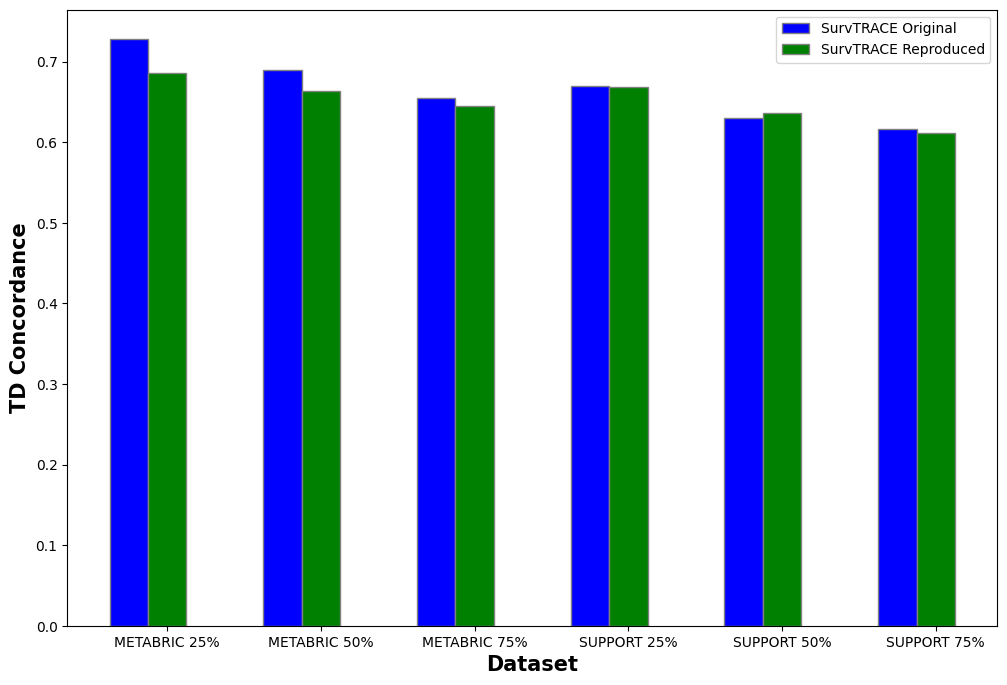

In [70]:
barWidth = 0.25
fig = plt.subplots(figsize=(12,8))

original = [0.728, 0.69, 0.655, 0.67, 0.63, 0.617]
reproduced = [0.686, 0.663, 0.645, 0.669, 0.636, 0.611]

br1 = np.arange(len(original))
br2 = [x + barWidth for x in br1]

plt.bar(br1, original, color ='b', width = barWidth,
        edgecolor ='grey', label ='SurvTRACE Original')
plt.bar(br2, reproduced, color ='g', width = barWidth,
        edgecolor ='grey', label ='SurvTRACE Reproduced')

plt.xlabel('Dataset', fontweight ='bold', fontsize = 15)
plt.ylabel('TD Concordance', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(original))],
        ['METABRIC 25%', 'METABRIC 50%', 'METABRIC 75%', 'SUPPORT 25%', 'SUPPORT 50%', 'SUPPORT 75%'])
 
plt.legend()
plt.show()

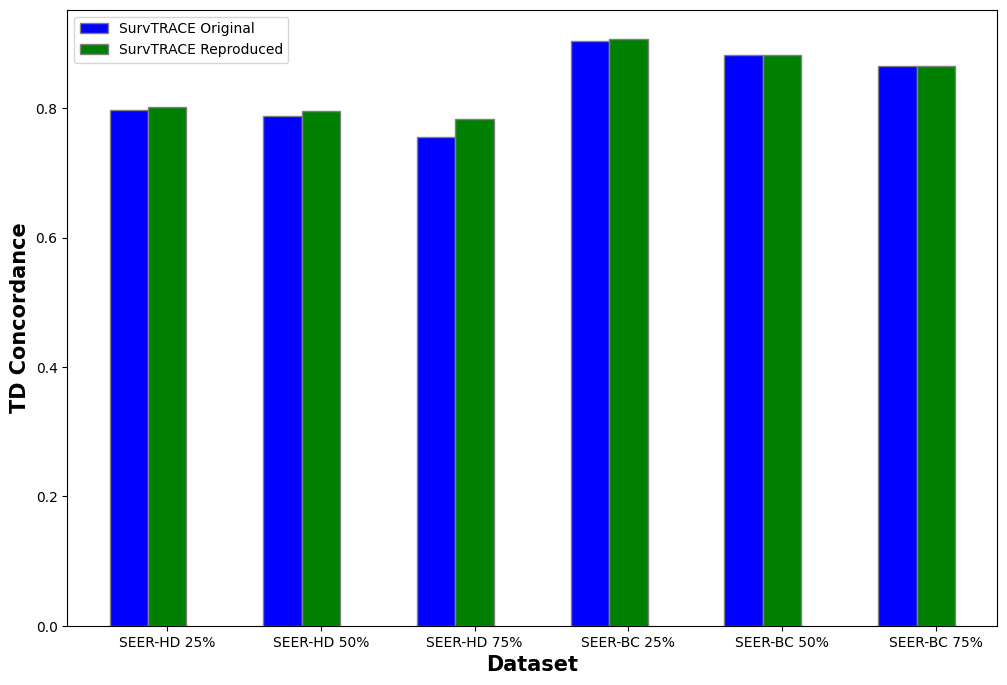

In [71]:
barWidth = 0.25
fig = plt.subplots(figsize=(12,8))

original = [0.797, 0.788, 0.755, 0.904, 0.883, 0.866]
reproduced = [0.802, 0.796, 0.784, 0.907, 0.883, 0.866]

br1 = np.arange(len(original))
br2 = [x + barWidth for x in br1]

plt.bar(br1, original, color ='b', width = barWidth,
        edgecolor ='grey', label ='SurvTRACE Original')
plt.bar(br2, reproduced, color ='g', width = barWidth,
        edgecolor ='grey', label ='SurvTRACE Reproduced')

plt.xlabel('Dataset', fontweight ='bold', fontsize = 15)
plt.ylabel('TD Concordance', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(original))],
        ['SEER-HD 25%', 'SEER-HD 50%', 'SEER-HD 75%', 'SEER-BC 25%', 'SEER-BC 50%', 'SEER-BC 75%'])

plt.legend()
plt.show()

## SurvTRACE - SEER - Loss Function Ablation
The SurvTRACE model without the logistic hazard loss function was trained with the SEER dataset and evaluated using TD concordance calculated by the evaluator object from the SurvTRACE package.

In [19]:
STConfig['data'] = 'seer'
STConfig['num_hidden_layers'] = 2
STConfig['hidden_size'] = 16
STConfig['intermediate_size'] = 64
STConfig['num_attention_heads'] = 2
STConfig['initializer_range'] = .02
STConfig['early_stop_patience'] = 5

df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(STConfig)
train_set = (df_train, df_y_train)
val_set = (df_val, df_y_val)


In [20]:
from survtrace.losses import NLLLogistiHazardLoss


hparams = {
    'batch_size': 1024,
    'weight_decay': 0,
    'learning_rate': 1e-4,
    'epochs': 100,
}
SurvTraceSeerLossAblation = SurvTraceMulti(STConfig).to(DEVICE)
SurvTraceSeerLossAblation_trainer = Trainer(SurvTraceSeerLossAblation)
SurvTraceSeerLossAblation_trainer.metrics = [NLLLogistiHazardLoss(),'NLLLogistiHazardLoss']
train_loss, val_loss = SurvTraceSeerLossAblation_trainer.fit((df_train, df_y_train), (df_val, df_y_val),
    batch_size=hparams['batch_size'],
    epochs=hparams['epochs'],
    learning_rate=hparams['learning_rate'],
    weight_decay=hparams['weight_decay'],
    val_batch_size=10000,)


use pytorch-cuda for training.
[Train-0]: 3.3905065165085047
[Val-0]: 2.419238328933716
[Train-1]: 0.7743622794443247
[Val-1]: 0.7256957292556763
[Train-2]: 0.7306951503364407
[Val-2]: 0.7213267683982849
[Train-3]: 0.7266384052987002
[Val-3]: 0.7198609113693237
[Train-4]: 0.7237218723816126
[Val-4]: 0.7145017981529236
[Train-5]: 0.721240260163132
[Val-5]: 0.7131412625312805
[Train-6]: 0.7201806927213863
[Val-6]: 0.7134824991226196
EarlyStopping counter: 1 out of 5
[Train-7]: 0.7191109663369705
[Val-7]: 0.7112871408462524
[Train-8]: 0.7186617099103474
[Val-8]: 0.7109307050704956
[Train-9]: 0.7181141800215455
[Val-9]: 0.7124578952789307
EarlyStopping counter: 1 out of 5
[Train-10]: 0.7176786667230178
[Val-10]: 0.710012674331665
[Train-11]: 0.7173169743852551
[Val-11]: 0.7101588845252991
EarlyStopping counter: 1 out of 5
[Train-12]: 0.7170577596644966
[Val-12]: 0.7096244096755981
[Train-13]: 0.7162235186619013
[Val-13]: 0.7095814943313599
[Train-14]: 0.7161229287280517
[Val-14]: 0.7097368

In [21]:
evaluator = Evaluator(df, df_train.index)
evaluator.eval(SurvTraceSeerLossAblation, (df_test, df_y_test))

******************************
start evaluation
******************************


c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con


Event: 0 For 0.25 quantile,
TD Concordance Index - IPCW: 0.9042126639737661
Brier Score: 0.03588776533595865
Event: 0 For 0.5 quantile,
TD Concordance Index - IPCW: 0.8826602563884307
Brier Score: 0.06029968900816516
Event: 0 For 0.75 quantile,
TD Concordance Index - IPCW: 0.8652698868042122
Brier Score: 0.08207141165758451
Event: 1 For 0.25 quantile,
TD Concordance Index - IPCW: 0.7888281552189829
Brier Score: 0.007393128898380241
Event: 1 For 0.5 quantile,
TD Concordance Index - IPCW: 0.7888654719993595
Brier Score: 0.015968243131562723
Event: 1 For 0.75 quantile,
TD Concordance Index - IPCW: 0.7780779250731416
Brier Score: 0.027951526741008745


defaultdict(list,
            {'0.25_ipcw_0': 0.9042126639737661,
             '0.25_brier_0': 0.03588776533595865,
             '0.5_ipcw_0': 0.8826602563884307,
             '0.5_brier_0': 0.06029968900816516,
             '0.75_ipcw_0': 0.8652698868042122,
             '0.75_brier_0': 0.08207141165758451,
             '0.25_ipcw_1': 0.7888281552189829,
             '0.25_brier_1': 0.007393128898380241,
             '0.5_ipcw_1': 0.7888654719993595,
             '0.5_brier_1': 0.015968243131562723,
             '0.75_ipcw_1': 0.7780779250731416,
             '0.75_brier_1': 0.027951526741008745})

## SurvTRACE - SEER - Transformer 
The SurvTRACE model without the transformer in the architecture was trained with the SEER dataset and evaluated using TD concordance calculated by the evaluator object from the SurvTRACE package.

In [22]:
from survtrace.modeling_bert import BertEncoderLame


class SurvTraceMultiAblation(SurvTraceMulti):
    def __init__(self, config: STConfig):
        super().__init__(config)
        self.encoder = BertEncoderLame(config)

hparams = {
    'batch_size': 1024,
    'weight_decay': 0,
    'learning_rate': 1e-4,
    'epochs': 100,
}
SurvTraceSeerEncoderAblation = SurvTraceMultiAblation(STConfig).to(DEVICE)
SurvTraceSeerEncoderAblation_trainer = Trainer(SurvTraceSeerEncoderAblation)
train_loss, val_loss = SurvTraceSeerEncoderAblation_trainer.fit((df_train, df_y_train), (df_val, df_y_val),
    batch_size=hparams['batch_size'],
    epochs=hparams['epochs'],
    learning_rate=hparams['learning_rate'],
    weight_decay=hparams['weight_decay'],
    val_batch_size=10000,)


use pytorch-cuda for training.
[Train-0]: 2.9514876125621146
[Val-0]: 2.0919079780578613
[Train-1]: 0.7364038932485645
[Val-1]: 0.6968504190444946
[Train-2]: 0.6962061210149
[Val-2]: 0.6863769292831421
[Train-3]: 0.690154683022272
[Val-3]: 0.6833231449127197
[Train-4]: 0.6876527539321354
[Val-4]: 0.6816166043281555
[Train-5]: 0.6863483973100882
[Val-5]: 0.6807183027267456
[Train-6]: 0.6856074501462535
[Val-6]: 0.6799182891845703
[Train-7]: 0.6851262519148742
[Val-7]: 0.6792891025543213
[Train-8]: 0.6843384473907704
[Val-8]: 0.6787375211715698
[Train-9]: 0.683669133453953
[Val-9]: 0.6785733699798584
[Train-10]: 0.683705289753116
[Val-10]: 0.6776801347732544
[Train-11]: 0.6831158571908263
[Val-11]: 0.6792948246002197
EarlyStopping counter: 1 out of 5
[Train-12]: 0.6824237957698147
[Val-12]: 0.6772336959838867
[Train-13]: 0.682305167726919
[Val-13]: 0.6776301264762878
EarlyStopping counter: 1 out of 5
[Train-14]: 0.6821443456776288
[Val-14]: 0.6770136952400208
[Train-15]: 0.68113999585716

In [23]:
evaluator = Evaluator(df, df_train.index)
evaluator.eval(SurvTraceSeerEncoderAblation, (df_test, df_y_test))

******************************
start evaluation
******************************


c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con


Event: 0 For 0.25 quantile,
TD Concordance Index - IPCW: 0.9038148991138182
Brier Score: 0.035724348473204964
Event: 0 For 0.5 quantile,
TD Concordance Index - IPCW: 0.8820874001469994
Brier Score: 0.06017103687127706
Event: 0 For 0.75 quantile,
TD Concordance Index - IPCW: 0.8650528721139195
Brier Score: 0.08165567512332446
Event: 1 For 0.25 quantile,
TD Concordance Index - IPCW: 0.7806379671444411
Brier Score: 0.007409649776910549
Event: 1 For 0.5 quantile,
TD Concordance Index - IPCW: 0.7814116178153309
Brier Score: 0.015987608899990718
Event: 1 For 0.75 quantile,
TD Concordance Index - IPCW: 0.7716941103998275
Brier Score: 0.027990005860478295


defaultdict(list,
            {'0.25_ipcw_0': 0.9038148991138182,
             '0.25_brier_0': 0.035724348473204964,
             '0.5_ipcw_0': 0.8820874001469994,
             '0.5_brier_0': 0.06017103687127706,
             '0.75_ipcw_0': 0.8650528721139195,
             '0.75_brier_0': 0.08165567512332446,
             '0.25_ipcw_1': 0.7806379671444411,
             '0.25_brier_1': 0.007409649776910549,
             '0.5_ipcw_1': 0.7814116178153309,
             '0.5_brier_1': 0.015987608899990718,
             '0.75_ipcw_1': 0.7716941103998275,
             '0.75_brier_1': 0.027990005860478295})

## Reproduced Ablation Results Compared to Original Paper

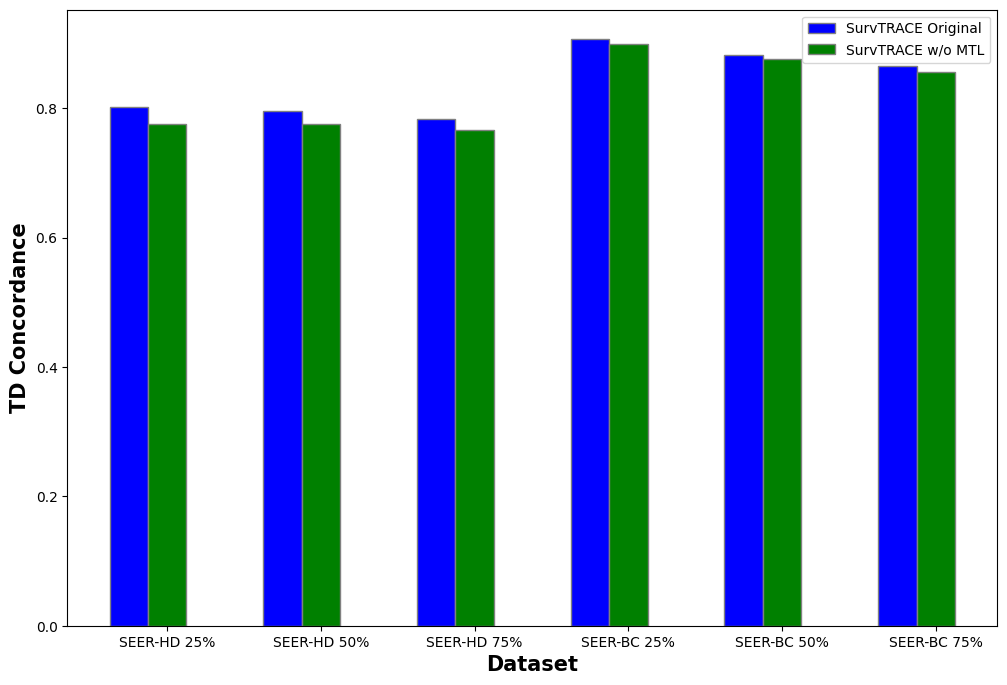

In [72]:
barWidth = 0.25
fig = plt.subplots(figsize=(12,8))

original = [0.802, 0.796, 0.784, 0.907, 0.883, 0.866]
no_transformer = [0.775, 0.775, 0.767, 0.899, 0.876, 0.856]

br1 = np.arange(len(original))
br2 = [x + barWidth for x in br1]

plt.bar(br1, original, color ='b', width = barWidth,
        edgecolor ='grey', label ='SurvTRACE Original')
plt.bar(br2, no_transformer, color ='g', width = barWidth,
        edgecolor ='grey', label ='SurvTRACE w/o MTL')

plt.xlabel('Dataset', fontweight ='bold', fontsize = 15)
plt.ylabel('TD Concordance', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(original))],
        ['SEER-HD 25%', 'SEER-HD 50%', 'SEER-HD 75%', 'SEER-BC 25%', 'SEER-BC 50%', 'SEER-BC 75%'])

plt.legend()
plt.show()

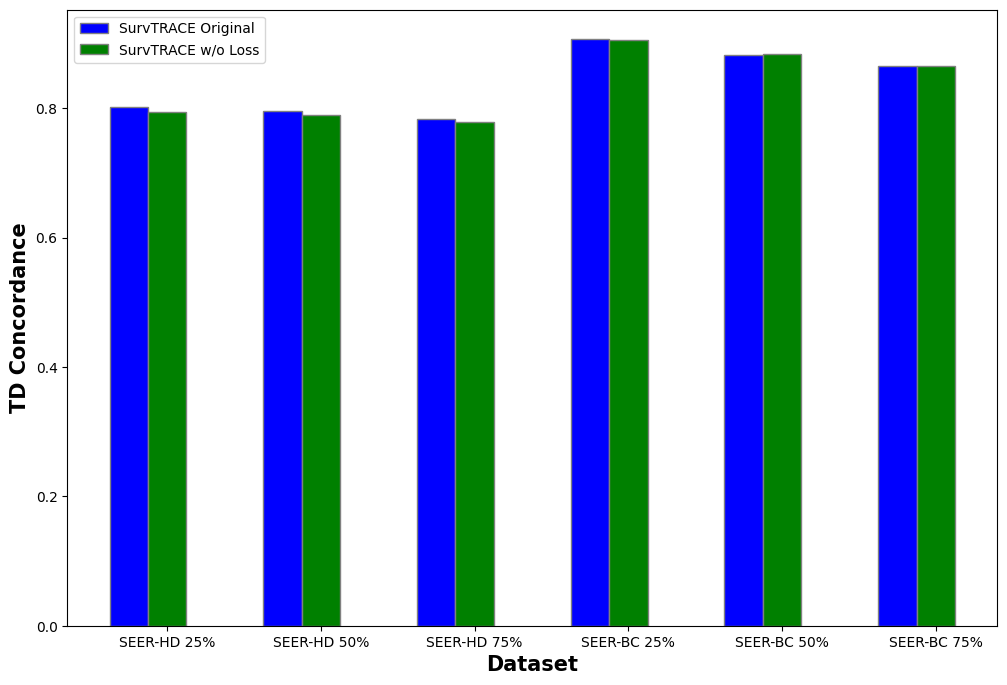

In [73]:
barWidth = 0.25
fig = plt.subplots(figsize=(12,8))

original = [0.802, 0.796, 0.784, 0.907, 0.883, 0.866]
no_loss = [0.794, 0.790, 0.778, 0.905, 0.884, 0.866]

br1 = np.arange(len(original))
br2 = [x + barWidth for x in br1]

plt.bar(br1, original, color ='b', width = barWidth,
        edgecolor ='grey', label ='SurvTRACE Original')
plt.bar(br2, no_loss, color ='g', width = barWidth,
        edgecolor ='grey', label ='SurvTRACE w/o Loss')

plt.xlabel('Dataset', fontweight ='bold', fontsize = 15)
plt.ylabel('TD Concordance', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(original))],
        ['SEER-HD 25%', 'SEER-HD 50%', 'SEER-HD 75%', 'SEER-BC 25%', 'SEER-BC 50%', 'SEER-BC 75%'])

plt.legend()
plt.show()

## SurvTRACE - SEER - Small Training Set Ablation
The SurvTRACE model was trained with 25%, 50%, and 75% of the SEER dataset. Performance was then evaluated using TD concordance calculated by the evaluator object from the SurvTRACE package.

In [50]:
df_train_subset_25 = df_train.sample(frac=0.25, random_state=4)
df_y_train_subset_25 = df_y_train.sample(frac=0.25, random_state=4)
df_val_subset_25 = df_val.sample(frac=0.25, random_state=4)
df_y_val_subset_25 = df_y_val.sample(frac=0.25, random_state=4)

df_train_subset_50 = df_train.sample(frac=0.5, random_state=2)
df_y_train_subset_50 = df_y_train.sample(frac=0.5, random_state=2)
df_val_subset_50 = df_val.sample(frac=0.5, random_state=2)
df_y_val_subset_50 = df_y_val.sample(frac=0.5, random_state=2)

df_train_subset_75 = df_train.sample(frac=0.75, random_state=3)
df_y_train_subset_75 = df_y_train.sample(frac=0.75, random_state=3)
df_val_subset_75 = df_val.sample(frac=0.75, random_state=3)
df_y_val_subset_75 = df_y_val.sample(frac=0.75, random_state=3)


In [51]:
hparams = {
    'batch_size': 1024,
    'weight_decay': 0,
    'learning_rate': 1e-4,
    'epochs': 100,
}
SurvTraceSeerSubsetAblation_25 = SurvTraceMulti(STConfig).to(DEVICE)
SurvTraceSeerSubsetAblation_trainer = Trainer(SurvTraceSeerSubsetAblation_25)
train_loss, val_loss = SurvTraceSeerSubsetAblation_trainer.fit((df_train_subset_25, df_y_train_subset_25), (df_val_subset_25, df_y_val_subset_25),
    batch_size=hparams['batch_size'],
    epochs=hparams['epochs'],
    learning_rate=hparams['learning_rate'],
    weight_decay=hparams['weight_decay'],
    val_batch_size=10000,)

SurvTraceSeerSubsetAblation_50 = SurvTraceMulti(STConfig).to(DEVICE)
SurvTraceSeerSubsetAblation_trainer = Trainer(SurvTraceSeerSubsetAblation_50)
train_loss, val_loss = SurvTraceSeerSubsetAblation_trainer.fit((df_train_subset_50, df_y_train_subset_50), (df_val_subset_50, df_y_val_subset_50),
    batch_size=hparams['batch_size'],
    epochs=hparams['epochs'],
    learning_rate=hparams['learning_rate'],
    weight_decay=hparams['weight_decay'],
    val_batch_size=10000,)

SurvTraceSeerSubsetAblation_75 = SurvTraceMulti(STConfig).to(DEVICE)
SurvTraceSeerSubsetAblation_trainer = Trainer(SurvTraceSeerSubsetAblation_75)
train_loss, val_loss = SurvTraceSeerSubsetAblation_trainer.fit((df_train_subset_75, df_y_train_subset_75), (df_val_subset_75, df_y_val_subset_75),
    batch_size=hparams['batch_size'],
    epochs=hparams['epochs'],
    learning_rate=hparams['learning_rate'],
    weight_decay=hparams['weight_decay'],
    val_batch_size=10000,)

use pytorch-cuda for training.
[Train-0]: 3.6383033378704175
[Val-0]: 3.303107261657715
[Train-1]: 0.8740759564412607
[Val-1]: 0.7134305834770203
[Train-2]: 0.7004364084553074
[Val-2]: 0.69972163438797
[Train-3]: 0.6903789969714912
[Val-3]: 0.692722499370575
[Train-4]: 0.6877409662749316
[Val-4]: 0.6904271245002747
[Train-5]: 0.6842449830996024
[Val-5]: 0.6893355846405029
[Train-6]: 0.682221760620942
[Val-6]: 0.687685489654541
[Train-7]: 0.6811024707716864
[Val-7]: 0.6869164705276489
[Train-8]: 0.6790530641336698
[Val-8]: 0.686418354511261
[Train-9]: 0.679289278146383
[Val-9]: 0.6856000423431396
[Train-10]: 0.6779002329787692
[Val-10]: 0.685648500919342
EarlyStopping counter: 1 out of 5
[Train-11]: 0.676651693679191
[Val-11]: 0.6848118305206299
[Train-12]: 0.6750364633830818
[Val-12]: 0.6842745542526245
[Train-13]: 0.675464241891294
[Val-13]: 0.6845588684082031
EarlyStopping counter: 1 out of 5
[Train-14]: 0.6746381472896885
[Val-14]: 0.6844701170921326
EarlyStopping counter: 2 out of 

In [52]:
evaluator = Evaluator(df, df_train_subset_25.index)
evaluator.eval(SurvTraceSeerSubsetAblation_25, (df_test, df_y_test))

evaluator = Evaluator(df, df_train_subset_50.index)
evaluator.eval(SurvTraceSeerSubsetAblation_50, (df_test, df_y_test))

evaluator = Evaluator(df, df_train_subset_75.index)
evaluator.eval(SurvTraceSeerSubsetAblation_75, (df_test, df_y_test))

******************************
start evaluation
******************************


c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con


Event: 0 For 0.25 quantile,
TD Concordance Index - IPCW: 0.9024245069092213
Brier Score: 0.036119970499025295
Event: 0 For 0.5 quantile,
TD Concordance Index - IPCW: 0.8804884371679839
Brier Score: 0.06073012026928682
Event: 0 For 0.75 quantile,
TD Concordance Index - IPCW: 0.8633853574556227
Brier Score: 0.08244832853952254
Event: 1 For 0.25 quantile,
TD Concordance Index - IPCW: 0.7794935555274383
Brier Score: 0.007413597230876317
Event: 1 For 0.5 quantile,
TD Concordance Index - IPCW: 0.7814279218733587
Brier Score: 0.016031327437667973
Event: 1 For 0.75 quantile,
TD Concordance Index - IPCW: 0.7731827069872558
Brier Score: 0.027941226403494356
******************************
start evaluation
******************************


c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con


Event: 0 For 0.25 quantile,
TD Concordance Index - IPCW: 0.9038779722473262
Brier Score: 0.036020923249415665
Event: 0 For 0.5 quantile,
TD Concordance Index - IPCW: 0.882017742540153
Brier Score: 0.06047776751461725
Event: 0 For 0.75 quantile,
TD Concordance Index - IPCW: 0.8647633308633004
Brier Score: 0.0819394813429894
Event: 1 For 0.25 quantile,
TD Concordance Index - IPCW: 0.7864621599149773
Brier Score: 0.007393320498374292
Event: 1 For 0.5 quantile,
TD Concordance Index - IPCW: 0.7888161604048115
Brier Score: 0.01595401062902678
Event: 1 For 0.75 quantile,
TD Concordance Index - IPCW: 0.7782585916927829
Brier Score: 0.027882306780009827
******************************
start evaluation
******************************


c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Jackie Chang\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con


Event: 0 For 0.25 quantile,
TD Concordance Index - IPCW: 0.9048534634633862
Brier Score: 0.035778494401842165
Event: 0 For 0.5 quantile,
TD Concordance Index - IPCW: 0.8830394723563246
Brier Score: 0.060133593636772224
Event: 0 For 0.75 quantile,
TD Concordance Index - IPCW: 0.8658917611340853
Brier Score: 0.08143018247962219
Event: 1 For 0.25 quantile,
TD Concordance Index - IPCW: 0.7892606947570407
Brier Score: 0.007386815620356723
Event: 1 For 0.5 quantile,
TD Concordance Index - IPCW: 0.7884247316553935
Brier Score: 0.01594305346680356
Event: 1 For 0.75 quantile,
TD Concordance Index - IPCW: 0.7785781880569452
Brier Score: 0.027829300098277093


defaultdict(list,
            {'0.25_ipcw_0': 0.9048534634633862,
             '0.25_brier_0': 0.035778494401842165,
             '0.5_ipcw_0': 0.8830394723563246,
             '0.5_brier_0': 0.060133593636772224,
             '0.75_ipcw_0': 0.8658917611340853,
             '0.75_brier_0': 0.08143018247962219,
             '0.25_ipcw_1': 0.7892606947570407,
             '0.25_brier_1': 0.007386815620356723,
             '0.5_ipcw_1': 0.7884247316553935,
             '0.5_brier_1': 0.01594305346680356,
             '0.75_ipcw_1': 0.7785781880569452,
             '0.75_brier_1': 0.027829300098277093})

## SurvTRACE - 5% SEER Ablation

In [53]:
# df_train_subset_5 = df_train.sample(frac=0.05, random_state=5)
# df_y_train_subset_5 = df_y_train.sample(frac=0.05, random_state=5)
# df_val_subset_5 = df_val.sample(frac=0.05, random_state=5)
# df_y_val_subset_5 = df_y_val.sample(frac=0.05, random_state=5)

In [54]:
# hparams = {
#     'batch_size': 1024,
#     'weight_decay': 0,
#     'learning_rate': 1e-4,
#     'epochs': 100,
# }
# SurvTraceSeerSubsetAblation_5 = SurvTraceMulti(STConfig).to(DEVICE)
# SurvTraceSeerSubsetAblation_trainer = Trainer(SurvTraceSeerSubsetAblation_5)
# train_loss, val_loss = SurvTraceSeerSubsetAblation_trainer.fit((df_train_subset_5, df_y_train_subset_5), (df_val_subset_5, df_y_val_subset_5),
#     batch_size=hparams['batch_size'],
#     epochs=hparams['epochs'],
#     learning_rate=hparams['learning_rate'],
#     weight_decay=hparams['weight_decay'],
#     val_batch_size=10000,)

In [55]:
# evaluator = Evaluator(df, df_train_subset_5.index)
# evaluator.eval(SurvTraceSeerSubsetAblation_5, (df_test, df_y_test))

## References
David R. Cox. 1992. Regression models and life-tables. Springer Series in Statistics, page 527–541.  
    
Christina Curtis, Sohrab P. Shah, Suet-Feung Chin,
Gulisa Turashvili, Oscar M. Rueda, Mark J. Dunning,
Doug Speed, Andy G. Lynch, Shamith Samarajiwa,
Yinyin Yuan, and et al. 2012. The genomic and tran-
scriptomic architecture of 2,000 breast tumours re-
veals novel subgroups. Nature, 486(7403):346–352.  
  
Bradley Efron. 1988. Logistic regression, survival anal-
ysis, and the kaplan-meier curve. Journal of the
American Statistical Association, 83(402):414–425.  
William A. Knaus. 1995. The support prognostic
model: Objective estimates of survival for seriously
ill hospitalized adults. Annals of Internal Medicine,
122(3):191. 
   
H  ̊avard Kvamme, Ørnulf Borgan, and Ida Scheel. 2019.
Time-to-event prediction with neural networks and
cox regression. Journal of Machine Learning Re-
search, 20(129):1–30.  
  
Changhee Lee, William Zame, Jinsung Yoon, and Mi-
haela Van der Schaar. 2018. Deephit: A deep learn-
ing approach to survival analysis with competing
risks. Proceedings of the AAAI Conference on Artifi-
cial Intelligence, 32(1).  
   
Chirag Nagpal, Xinyu Li, and Artur Dubrawski. 2021.
deep survival machines: Fully parametric survival
regression and representation learning for censored
data with competing risks. IEEE Journal of Biomedi-
cal and Health Informatics, 25(8):3163–3175.  
   
National Cancer Institute. 2021. Surveillance,
epidemiology, and end results (seer) program
(www.seer.cancer.gov) seer*stat database: Incidence - seer research data, 8 registries, nov 2021 sub (1975-
2019) - linked to county attributes - time dependent
(1990-2019) income/rurality, 1969-2020 counties.
Technical report, National Cancer Institute, DCCPS,
Surveillance Research Program.  
    
Zifeng Wang and Jimeng Sun. 2022. Survtrace: Trans-
formers for survival analysis with competing events.
Proceedings of the 13th ACM International Confer-
ence on Bioinformatics, Computational Biology and
Health Informatics.  
